# IBM's Qiskit Global Summer School 2024

## Lab 3 - Quantum Error Suppression and Mitigation with Qiskit Runtime

In this lab, you will explore the error suppression and error mitigation options available with the Estimator primitive from Qiskit Runtime. You will construct a circuit and observables and submit jobs using the Estimator primitive using different combinations of error mitigation settings. Then, you will plot the results to observe the effects of the various settings.

These are the error suppression and mitigation options you will use:

- Dynamical decoupling
- Measurement error mitigation
- Gate twirling
- Zero noise extrapolation (ZNE)

### Quantum problem (circuit and observables)

#### Circuit

This lab uses the [`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) circuit included in Qiskit's circuit library.

EfficientSU2 is a parameterized quantum circuit designed to be efficiently executable on quantum hardware with limited qubit connectivity, while still being expressive enough to solve problems in application domains like optimization and chemistry. It is built by alternating layers of parameterized single-qubit gates with a layer containing a fixed pattern of two-qubit gates, for a chosen number of repetitions. The pattern of two-qubit gates can be specified by the user. Here you can use the built-in pairwise pattern because it minimizes the circuit depth by packing the two-qubit gates as densely as possible.

In [10]:
from qiskit.circuit.library import EfficientSU2

num_qubits = 50
reps = 2
abstract_circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
simple_circ = EfficientSU2(4, reps=2, entanglement="pairwise")

In [11]:
simple_circ.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                     ├
«     │                                                                                                                                                      │
«q_1: ┤1                                                                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23]) │
«q_2: ┤2                                                                                                                                                     ├
«     │                                                                                                                                                      │
«q_3: ┤3                                                                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

##### Assign parameters

Next, create some random parameters and assign them to the circuit.

In [12]:
import numpy as np

num_parameters = abstract_circuit.num_parameters
param_values = np.random.uniform(-np.pi, np.pi, size=num_parameters)

abstract_circuit.assign_parameters(param_values, inplace=True)

##### Append uncompute block

At the end of the lab, you want to compare the output of the quantum computer with the ideal answer. For small quantum circuits you can calculate this value by simulating the circuit on a classical computer, but this is not possible for larger, utility-scale circuits. You can work around this issue with the "mirror circuit" technique (also known as "compute-uncompute"), which is useful for benchmarking the performance of quantum devices.

In the mirror circuit technique, you concatenate the circuit with its inverse, which is formed by inverting each gate of the circuit in reverse order. The resulting circuit implements the identity operator, which can trivially be simulated. Because the structure of the original circuit is preserved in the mirror circuit, executing the mirror circuit still gives an idea of how the quantum device would perform on the original circuit.

The following code cell constructs the mirror circuit using the [`UnitaryOverlap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UnitaryOverlap) class from Qiskit's circuit library. Before mirroring the circuit, append a barrier instruction to it to prevent the transpiler from merging the two parts of the circuit on either side of the barrier. Without the barrier, the transpiler would merge the original circuit with its inverse, resulting in a transpiled circuit without any gates.

In [13]:
from qiskit.circuit.library import UnitaryOverlap

abstract_circuit.barrier()
abstract_circuit = UnitaryOverlap(abstract_circuit, abstract_circuit)

It is recommended to draw the circuit to visualize what you are going to run. However, a 50-qubit circuit may be too dense to visualize effectively. Therefore, create a smaller abstract circuit with 4 qubits by following the above steps (i.e., create a 4-qubit `EfficientSU2` circuit, assign parameters, and append uncomput block). Then, draw the circuit by following one of the [visualization techniques](https://docs.quantum.ibm.com/build/circuit-visualization). Note that the 4-qubit circuit is only for visualization. You must execute the 50-qubit circuit with error mitigation and suppression.

#### Observables

Next, define the observables. You will create weight-1 $\langle Z_i \rangle$ observables for each qubit in the circuit. Example: For a $4$-qubit abstract circuit, you will create $4$ observables each with a single $\langle Z \rangle$ acting on a different qubit, i.e., $IIIZ$, $IIZI$, $IZII$, and $ZIII$.

In [14]:
from qiskit.quantum_info import SparsePauliOp

paulis = ["".join("Z" if i == q else "I" for i in range(num_qubits)) for q in range(num_qubits)]
abstract_observables = [SparsePauliOp(pauli) for pauli in paulis]

### Optimize

You must optimize your circuit (and observables) and make them target hardware compatible before executing. You need to choose the hardware device to use before optimizing your circuit. The following code cell requests the least busy utility-scale device with at least 127 qubits.

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)
backend.name

'ibm_kyoto'

#### Target circuit

Optimizing you circuit involves transpiling it for your chosen backend. You can transpile your circuit by creating a pass manager and then running the pass manager on the circuit. An easy way to create a pass manager is to use the [`generate_preset_pass_manager`](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function. You have learnt about transpilation and pass managers in an earlier lab.

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
target_circuit = pm.run(abstract_circuit)

#### Target observables

The transpilation process has mapped the virtual qubits of the abstract circuit to physical qubits on the hardware. The information about the qubit layout is stored in the layout attribute of the transpiled target circuit. The observables were defined in terms of the virtual qubits, so you need to apply this layout to the observables, which you can do with the [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [18]:
layout = target_circuit.layout
target_observables = [abs_obs.apply_layout(layout=layout) for abs_obs in abstract_observables]

### Execute
(_Excercises_)

Now, execute the target circuit and observables with different configurations of error suppression and mitigation from the `Estimator` primitive. You will perform **seven excercises** where you submit seven different jobs (each with same circuit and observables) with following settings.

- **Excercise-1**: No suppression/mitigation (_worked out for reference_)
- **Excercise-2**: Dynamical Decoupling
- **Excercise-3**: Measurement Mitigation (TREX)
- **Excercise-4**: Zero Noise Extrapolation (ZNE)
   - _Excercise-4a_: ZNE (exponential extrapolator)
   - _Excercise-4b_: ZNE (linear extrapolator)
- **Excercise-5**: ZNE + Gate Twirling
- **Excercise-6**: All

You need to refer to Qiskit Runtime docs to successfully complete the excercises in this lab. Some helpful and necessary links are below:
1. https://docs.quantum.ibm.com/run/error-mitigation-explanation
2. https://docs.quantum.ibm.com/run/configure-error-mitigation
3. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/options
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.MeasureNoiseLearningOptions
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions
   - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions
  
Read the comments in the next code cell for deatils of each excercise and hints.

**Note 1**

Some suppression and mitigation options are enabled by default (e.g., measurement twirling is enabled by default). Therefore, if you want to selectively enable one or more options, inspect the default options first and explicitly disable unwanted options, if necessary.

One way is to [turn off all mitigation and suppression first](https://docs.quantum.ibm.com/run/configure-error-mitigation#turn-off-all-error-mitigation-and-error-suppression), then selectively turn on your desired options.

Also, refer to the [Qiskit Runtime API docs](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime) for default options.

**Note 2**

It is recommended to submit multiple non-iterative jobs inside a [`Batch`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Batch) [execution mode](https://docs.quantum.ibm.com/run/execution-modes) of Qiskit Runtime (See also [Run jobs in batch](https://docs.quantum.ibm.com/run/run-jobs-batch)) to leverage the parallelization offered by batch and minimize delay between jobs. For example, if you are an open plan users, you can submit $3$ jobs together in the `Batch` execution mode.

In [19]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Batch

# Define the primitive unified bloc (PUB) for Estimator jobs
# More on PUB: https://docs.quantum.ibm.com/api/qiskit/primitives
pub = (target_circuit, target_observables)
default_shots = 10_000

# list for saving job results
primitive_results = []

# Submit Exercise 1 to 3 inside a Batch execution mode
with Batch(backend=backend) as batch:
    # Excercise-1: No mitigation (worked out for you)
    ## https://docs.quantum.ibm.com/run/configure-error-mitigation#turn-off-all-error-mitigation-and-error-suppression
    options_ex1 = EstimatorOptions() # some suppression and mitigation are enabled by default
    options_ex1.optimization_level = 0
    options_ex1.resilience_level = 0
    options_ex1.default_shots = default_shots
    
    # Instantiate `Estimator` with options
    estimator = Estimator(options=options_ex1)
    # Submit job
    job_ex1 = estimator.run(pubs=[pub])

    
    # Excercise-2: Dynamical Decoupling (DD)
    options_ex2 = EstimatorOptions()
    options_ex2.default_shots = default_shots
    # Configure options to only enable DD with XX
    options_ex2.resilience_level = 0
    options_ex2.optimization_level = 0
    options_ex2.dynamical_decoupling.sequence_type = 'XX'

    """Your code goes here.
        
        Configure options to only enable DD with a 'XX' sequence.
        
        Hint: First, turn off all error suppression and mitigation. Then, turn on DD related options only.
            1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
            2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions
            3. https://docs.quantum.ibm.com/run/error-mitigation-explanation#dynamical-decoupling
    """
    
    estimator = Estimator(options=options_ex2)
    job_ex2 = estimator.run(pubs=[pub])

    
    # Excercise-3: Measurement mitigation (TREX)
    options_ex3 = EstimatorOptions()
    options_ex3.default_shots = default_shots

    options_ex3.resilience = {"measure_mitigation": True}

    """Your code goes here.
    
        Configure options to enable measurement mitigation only.
        
        Hint:
            1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
            2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2
            3. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions
            4. https://docs.quantum.ibm.com/run/configure-error-mitigation
    """
    
    estimator = Estimator(options=options_ex3)
    job_ex3 = estimator.run(pubs=[pub])

# Wait for first 3 jobs to complete. Fetch results when done
primitive_results.append(job_ex1.result())
primitive_results.append(job_ex2.result())
primitive_results.append(job_ex3.result())



In [ ]:
# Submit Exercise 4a, 4b, and 5 inside another Batch execution mode
with Batch(backend=backend) as batch:
    # Excercise-4a: Zero Noise Extrapolation (extrapolator="exponential" | noise_factors=(1, 3, 5))
    options_ex4a = EstimatorOptions()
    options_ex4a.default_shots = default_shots
    """Your code goes here.
        
        Configure options to only enable ZNE with the exponential extrapolator and default noise factors (1, 3, 5).
        
        Hint:
            1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
            2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2
            3. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions
    """
    options_ex4a.zne_options.extrapolator = "exponential"
    options_ex4a.zne_options.noise_factors = (1, 3, 5)
    estimator = Estimator(options=options_ex4a)
    job_ex4a = estimator.run(pubs=[pub])

    
    # Excercise-4b: Zero Noise Extrapolation (use: extrapolator="linear" and noise_factors=(1, 3, 5))
    options_ex4b = EstimatorOptions()
    options_ex4b.default_shots = default_shots
    """Your code goes here.
        
        Configure options to only enable ZNE with the linear extrapolator and default noise factors (1, 3, 5).
        
        Hint:
            1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
            2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2
            3. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions
    """
    options_ex4b.zne_options.extrapolator = "linear"
    options_ex4b.zne_options.noise_factors = (1, 3, 5)
    estimator = Estimator(options=options_ex4b)
    job_ex4b = estimator.run(pubs=[pub])

    
    # Excercise-5: Gate Twirling + Zero Noise Extrapolation (use: extrapolator=("exponential", "linear") and noise_factors=(1, 3, 5))
    options_ex5 = EstimatorOptions()
    options_ex5.default_shots = default_shots
    """Your code goes here.
    
        Configure options to enable gate twirling and ZNE.
        Instead of a single extrapolator, set a sequence of extrapolators, i.e., ("exponential", "linear"), in ZneOptions. 
        Make sure to turn off any measurment twirling and measurement mitigation.
        
        Hint:
            1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
            2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2
            3. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions
            4. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions
    """
    options_ex5.twirling_options.gate_twirling = True
    options_ex5.zne_options.extrapolator = ("exponential", "linear")
    options_ex5.zne_options.noise_factors = (1, 3, 5)
    options_ex5.twirling_options.meas_twirling = False
    options_ex5.resilience_options.trex = False
    estimator = Estimator(options=options_ex5)
    job_ex5 = estimator.run(pubs=[pub])

# Wait for next 3 jobs to complete. Fetch results when done
primitive_results.append(job_ex4a.result())
primitive_results.append(job_ex4b.result())
primitive_results.append(job_ex5.result())

# Submit Exercise 6 in Job execution mode as it is a single job
# Excercise-6: All
options_ex6 = EstimatorOptions()
options_ex6.default_shots = default_shots
"""Your code goes here.
    
    Configure options to enable all suppression and mitigation options, i.e., DD, measurement mitigation,
    gate twirling, and ZNE. Keep using the same sequence of extrapolators and noise factors from excercise-5 for ZNE.
    
    Hint:
        1. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
        2. https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions
        3. https://docs.quantum.ibm.com/run/configure-error-mitigation#configure-estimator-v2-with-resilience-levels
"""

# Note: explicitly set `mode=backend` in Job execution mode.
# Inside Batch context manager, `Estimator` knows the context/backend implicitly
# However, without the context manager, we must set `mode` explicitly
options_ex6.dynamical_decoupling.sequence = 'XX'
options_ex6.resilience_options.trex = True
options_ex6.twirling_options.gate_twirling = True
options_ex6.zne_options.extrapolator = ("exponential", "linear")
options_ex6.zne_options.noise_factors = (1, 3, 5)
options_ex6.twirling_options.meas_twirling = False

estimator = Estimator(mode=backend, options=options_ex6)
job_ex6 = estimator.run(pubs=[pub])
primitive_results.append(job_ex6.result())

### Analyze

1. Each [`PrimtiveResult`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PrimitiveResult) will have a list-like structure with a single [`PubResult`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.PubResult) (as we submitted a single PUB).
   - The `PubResult` will contain an array of expectation values each corresponding to an observable inside its [`data`](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.DataBin) container (`pub_result.data.evs`). For each qubit in the `abstract_circuit`, we have one weight-1 $\langle Z \rangle$ observable.
2. Compute the average of expectation values in each `PubResult`.
3. Plot (bar chart) average expectation values and analyze how different error suppression and mitigation methods are improving results. Note that due the compute-uncompute structure of the circuit, the ideal average expecation value is $1.0$ for each job respectively. 

Now, try to understand the results based on the knowledge from the lecture. We suggest looking at the structure of the circuit by following one of the visualization methods described [here](https://docs.quantum.ibm.com/build/circuit-visualization).

In [ ]:
#Your code for analyzing results goes here

In [ ]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()

/tmp/ipykernel_1416730/265296017.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  qc_draw.show()


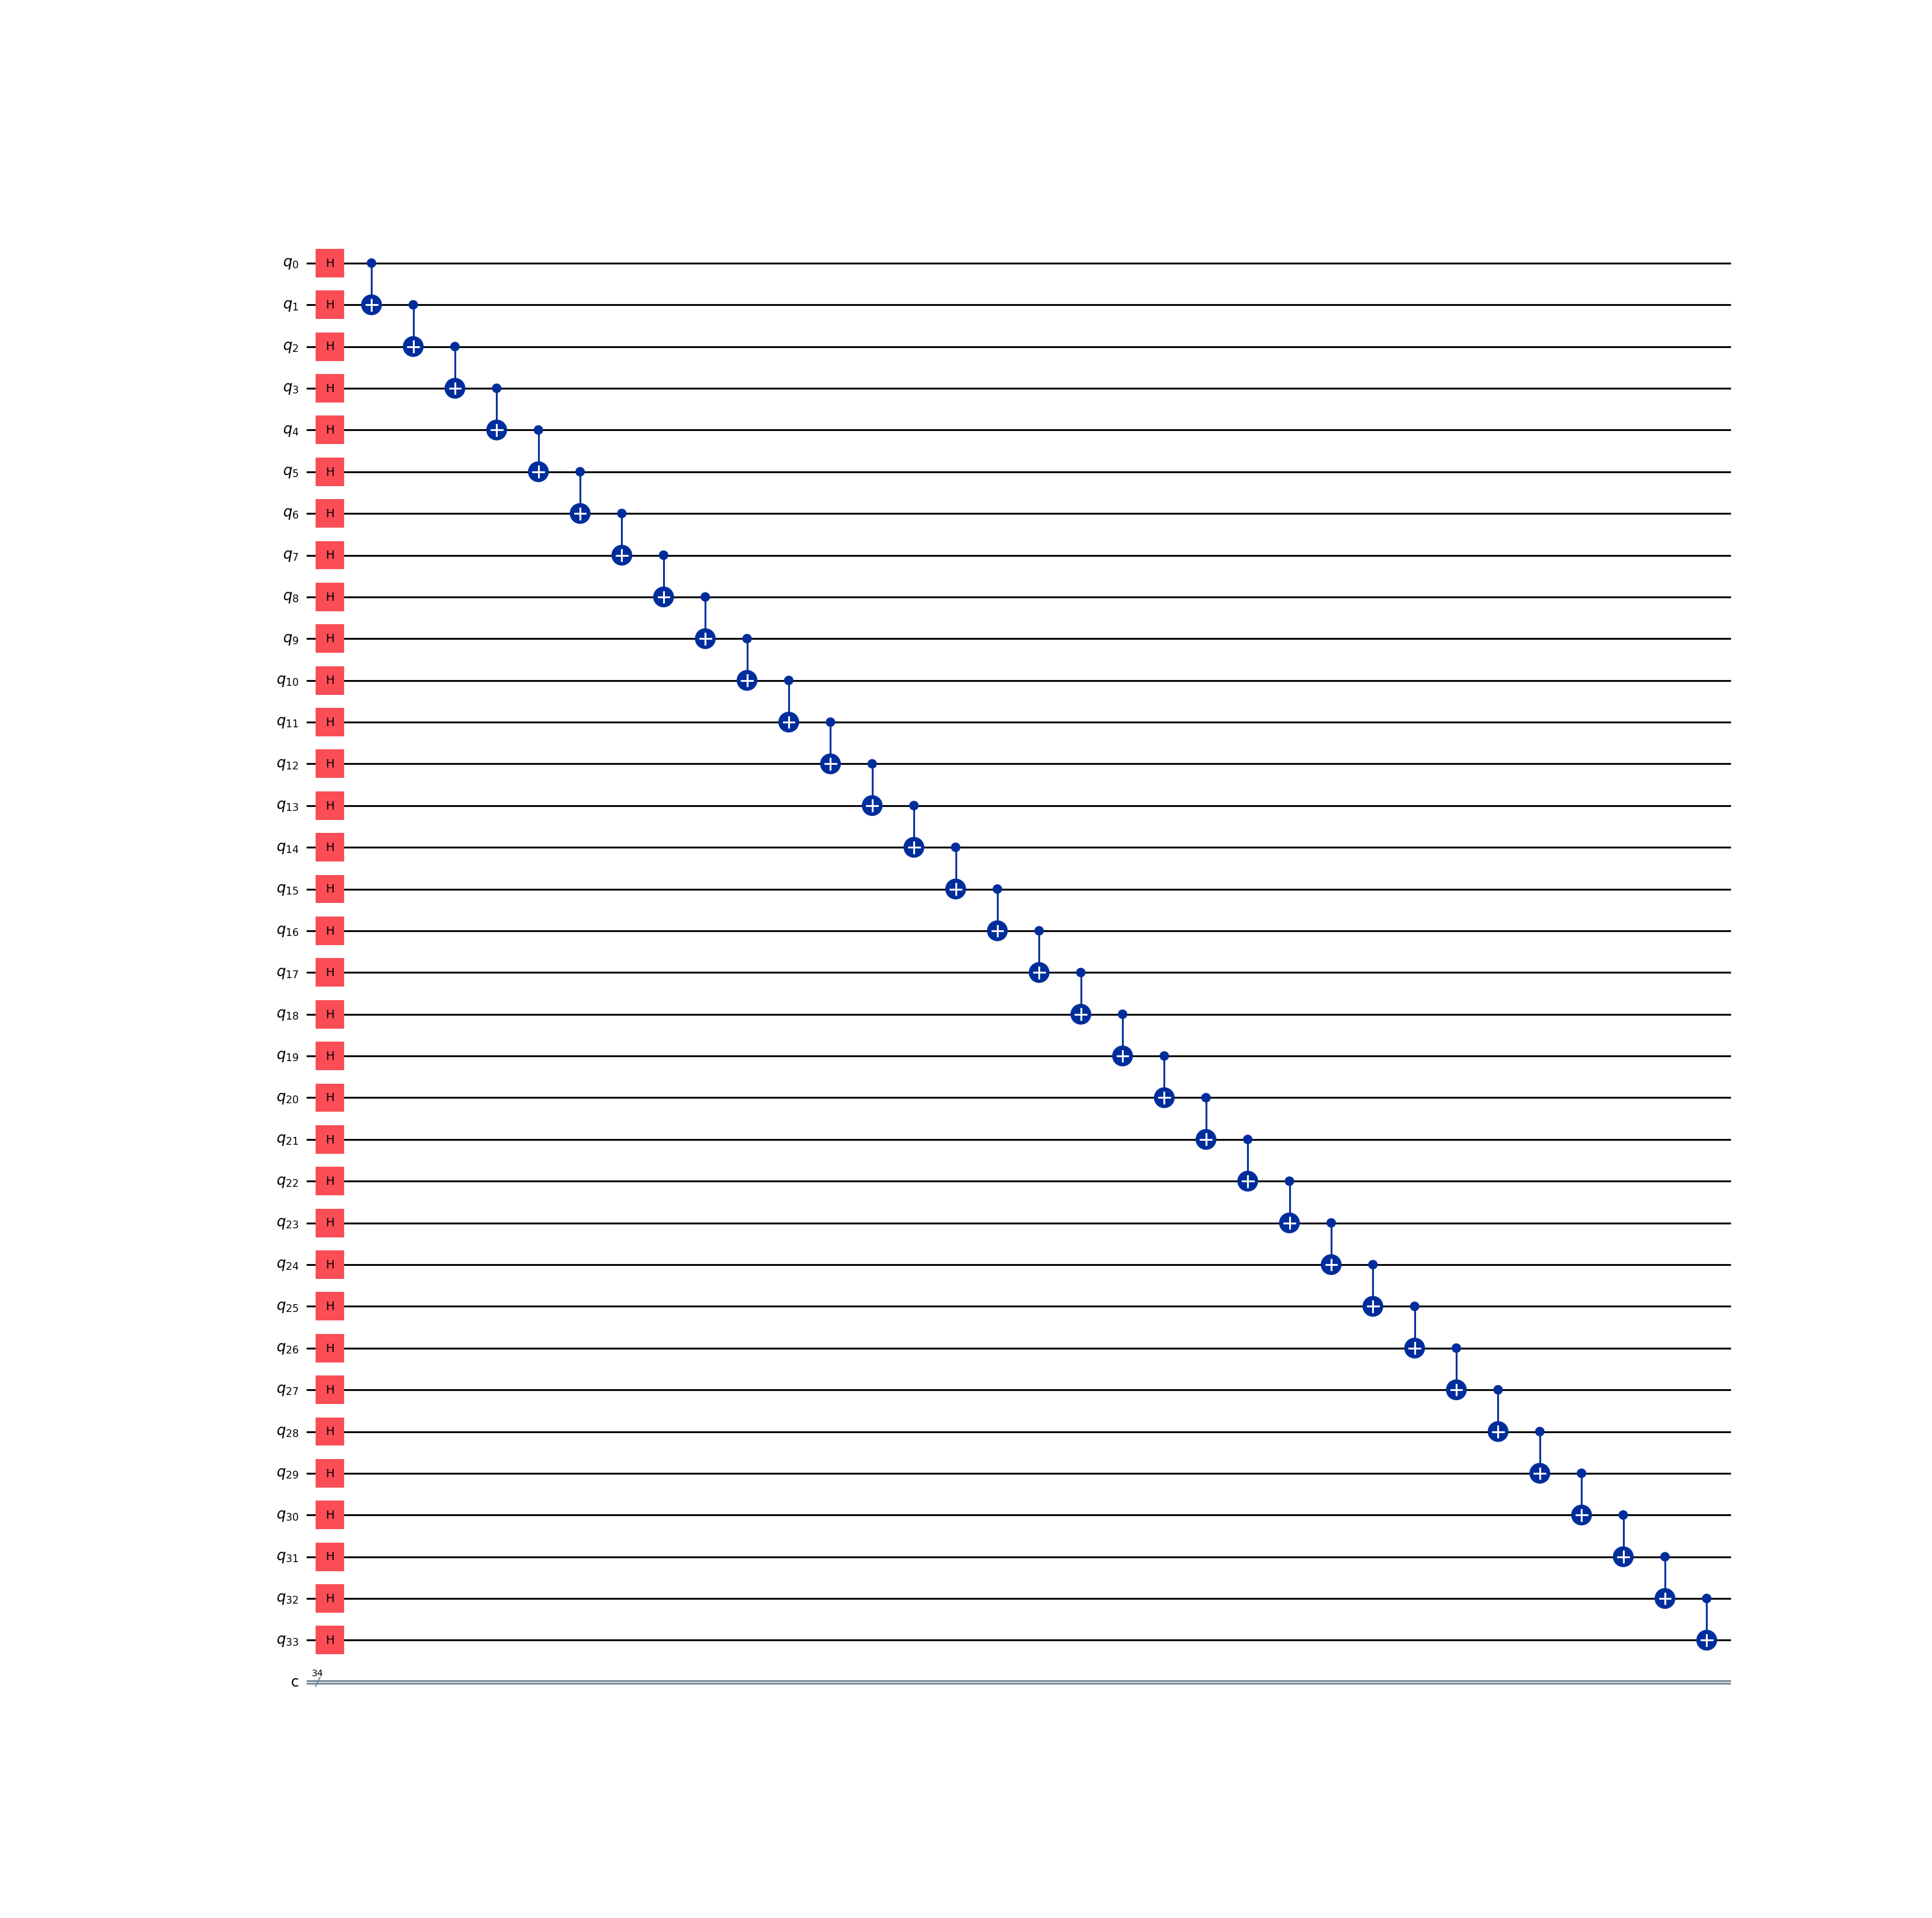

In [ ]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
# Create a Quantum Circuit with 34 qubits and 34 classical bits
num_qubits = 34
qc = QuantumCircuit(num_qubits, num_qubits)

# Apply a Hadamard gate on all qubits to create superposition
for qubit in range(num_qubits):
    qc.h(qubit)
# Apply CNOT gates between each pair of adjacent qubits
for qubit in range(num_qubits - 1):
    qc.cx(qubit, qubit + 1)
# Measure all qubits
# qc.measure(range(num_qubits), range(num_qubits))
# Create a Matplotlib figure with a 1:5 width-to-height ratio
fig, ax = plt.subplots(figsize=(5, 25))
ax.axis('off')  # Turn off the axis

# Draw the quantum circuit onto the Matplotlib figure
# 

# Draw the circuit
qc_draw = circuit_drawer(qc, output='mpl', fold=-1, ax=ax,vertical_compression='high', justify='left')
#qc_draw.show()
ax.imshow(qc_draw)
qc_draw.savefig('quantum_circuit.png')

from PIL import Image
import IPython.display as display

img = Image.open('quantum_circuit.png')
display.display(img)